In [1]:
#目的：为了搜索到DESI发现的那个QP
#方法：利用 SPARCL's client.find()

In [6]:
# SPARCL imports
from sparcl.client import SparclClient

# 3rd party imports
import numpy as np
import astropy.units as u
from specutils import Spectrum1D
from astropy.nddata import InverseVariance
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Data Lab imports
from dl import queryClient as qc
from dl import authClient as ac
from getpass import getpass

# plots default setup
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

In [8]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'i_am_your_father'

In [11]:
client = SparclClient()
client

(sparclclient:1.2.0, api:9.0, https://astrosparcl.datalab.noirlab.edu/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

In [13]:
client.find?

In [14]:
out = ['sparcl_id', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'ra': [216.00, 216.01],
        'dec': [34.61,34.67],
       'spectype': ['QSO']}

In [15]:
found_I = client.find(outfields=out, constraints=cons, limit=20)
["%s, %s, %f, %f, %f" % (f.sparcl_id, f.data_release, f.ra, f.redshift, f.redshift_err)
 for f in found_I.records]

['3eec12ac-d097-4516-ae9c-f6454d9981e6, DESI-EDR, 216.009299, 2.011745, 0.000328',
 '7d7b8ed5-da5f-433f-a6a9-914b47c7ca83, BOSS-DR16, 216.009590, 2.019197, 0.000584',
 'bd20843a-f720-45fd-9798-4ca156de738c, DESI-EDR, 216.009599, 2.012616, 0.000208',
 'c1117021-c56a-4bc1-9087-e0547cdd81fa, BOSS-DR16, 216.009270, 2.007812, 0.001563']

In [17]:
# Define the fields to include in the retrieve function
inc = ['sparcl_id', 'specid', 'data_release', 'redshift', 'flux',
       'wavelength', 'model', 'ivar', 'mask', 'spectype', 'ra', 'dec']

In [18]:
ids_I = found_I.ids
results_I = client.retrieve(uuid_list=ids_I, include=inc)
results_I.info

{'status': {'success': True,
  'info': ["Successfully found 4 records in dr_list=['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR']"],
  'warnings': []}}

In [19]:
records_I = results_I.records[0]

id_I = records_I.sparcl_id
data_release_I = records_I.data_release
redshift_I = records_I.redshift
flux_I = records_I.flux
wavelength_I = records_I.wavelength
model_I = records_I.model
ivar_I = records_I.ivar
mask_I = records_I.mask
spectype_I = records_I.spectype

In [20]:
df = pd.DataFrame([[r.sparcl_id, r.redshift, r.wavelength, r.flux,]
                    for r in results_I.records],
                  columns=['sparcl_id', 'redshift', 'wavelength', 'flux'])
df

,sparcl_id,redshift,wavelength,flux
0,3eec12ac-d097-4516-ae9c-f6454d9981e6,2.011745,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[1.4501694440841675, -2.7344412803649902, -1.5..."
1,7d7b8ed5-da5f-433f-a6a9-914b47c7ca83,2.019197,"[3562.049907308445, 3562.8701940455303, 3563.6...","[14.018193244934082, 3.2535312175750732, 2.374..."
2,bd20843a-f720-45fd-9798-4ca156de738c,2.012616,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[2.5954880714416504, 3.770533323287964, 3.9827..."
3,c1117021-c56a-4bc1-9087-e0547cdd81fa,2.007812,"[3599.15043999954, 3599.9792704335687, 3600.80...","[-6.555478096008301, -6.556015491485596, -6.55..."


In [21]:
specs = [Spectrum1D(spectral_axis = r.wavelength*u.AA,
                    flux = np.array(r.flux)* 10**-17 * u.Unit('erg cm-2 s-1 AA-1'),
                    uncertainty = InverseVariance(np.array(r.ivar)),
                    redshift = r.redshift,
                    mask = r.mask)
        for r in results_I.records]
specs[0]

<Spectrum1D(flux=<Quantity [ 1.45016944e-17, -2.73444128e-17, -1.54966211e-17, ...,
            3.88902605e-18,  6.16273344e-18,  3.13628554e-18] erg / (Angstrom s cm2)>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=240254.33981404448 km / s
      redshift=2.011744637408129)
  [3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ] Angstrom>, uncertainty=InverseVariance([  0.3051073 ,   0.31321165,   0.26794136, ...,
                  68.1264801 ,  79.37541199, 115.43138123]))>

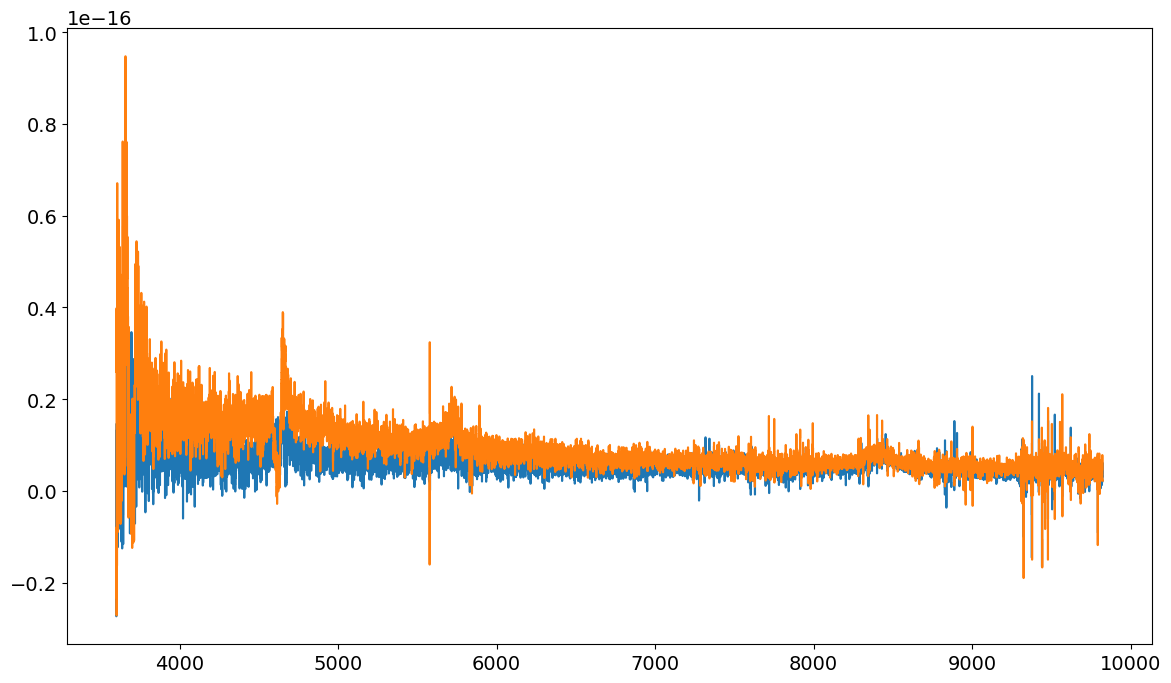

In [23]:
# Plot a couple
f, ax = plt.subplots()  
ax.step(specs[0].spectral_axis, specs[0].flux) 
ax.step(specs[2].spectral_axis, specs[2].flux)
plt.show()

In [24]:
def plot_spec(index, results):
    """
    Pass an index value and the output from using client.retrieve()
    to plot the spectrum at the specified index.
    """
    
    record = results.records[index]

    sparcl_id = record.sparcl_id
    data_release = record.data_release
    flux = record.flux
    wavelength = record.wavelength
    model = record.model
    spectype = record.spectype
    redshift = record.redshift
    ra = record.ra
    dec = record.dec

    plt.title(f"Data Set = {data_release}\n"
              f"Type = {spectype}\n"
              f"ID = {sparcl_id}\n"
              f"Redshift = {redshift}\n"
              f"RA = {ra}\n"
              f"Dec = {dec}", loc='left')
    plt.xlabel('$\lambda\ [\AA]$')
    plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
    
    # Plot unsmoothed spectrum in grey
    plt.plot(wavelength, flux, color='k', alpha=0.2, label='Unsmoothed spectrum')
    
    # Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
    plt.plot(wavelength, convolve(flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')
    
    # Overplot the model spectrum in red
    plt.plot(wavelength, model, color='r', label='Model spectrum')
    
    plt.legend()
    plt.show()

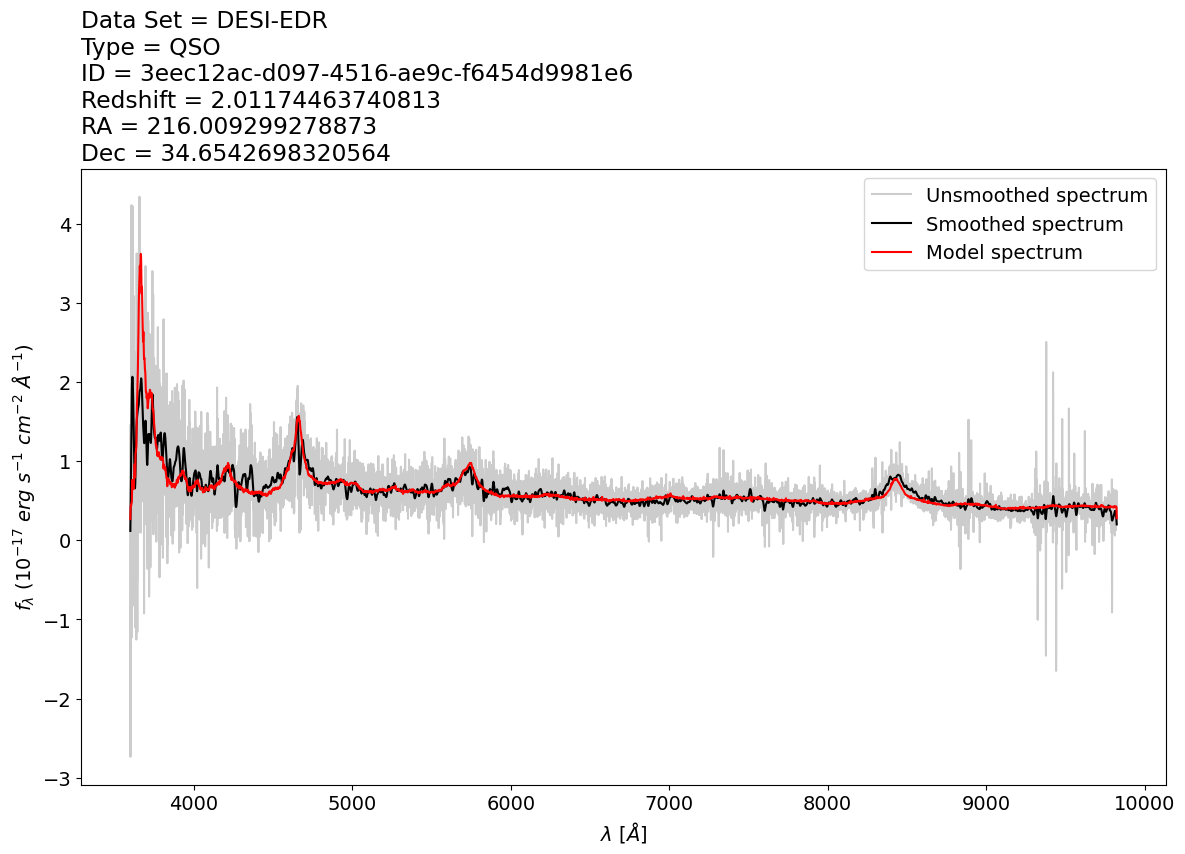

In [25]:
plot_spec(index=0, results=results_I)

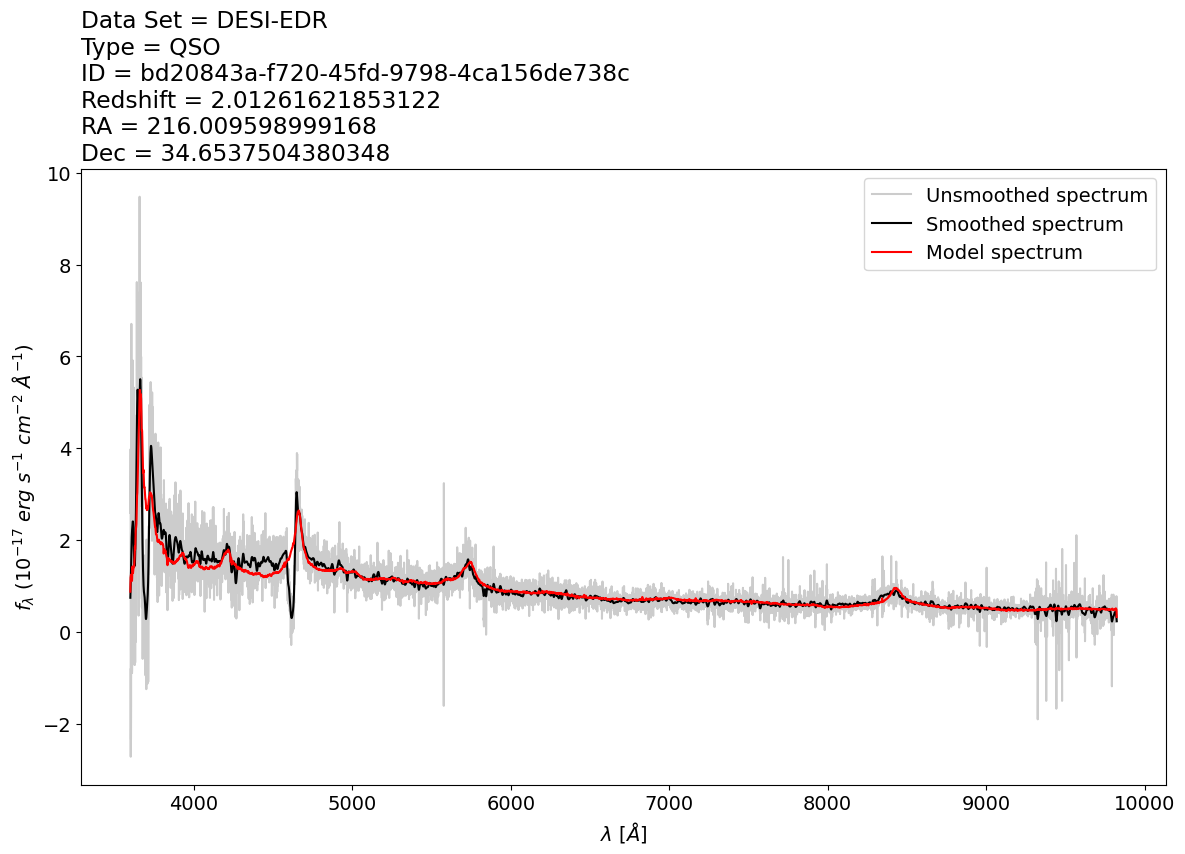

In [26]:
plot_spec(index=2, results=results_I)